In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import PIL
from keras.preprocessing.image import load_img


import pickle
import time

Using TensorFlow backend.


In [128]:
from PIL import ImageDraw
from keras.applications import imagenet_utils
from keras.preprocessing.image import img_to_array,array_to_img
from IPython.display import Image,display


inputShape = (224, 224)
preprocess = imagenet_utils.preprocess_input

def preprocess_DF(bbox):
    image = crop_resize_DF(bbox)
    image = img_to_array(image)
    image = np.expand_dims(image,axis=0)
    
    return preprocess(image)

def preprocess_file(file):
    image = PIL.Image.open(file)
    image = image.resize(inputShape, PIL.Image.ANTIALIAS)
    image = img_to_array(image)
    image = np.expand_dims(image,axis=0)
    
    return preprocess(image)

def crop_resize_DF(bbox):
    img = PIL.Image.open('Data/DeepFashion/'+bbox['image_name'])
    lx = bbox['x_1']
    ly = bbox['y_1']
    ux = bbox['x_2']
    uy = bbox['y_2']
    
    img = img.crop((lx,ly,ux,uy))
    img = img.resize(inputShape, PIL.Image.ANTIALIAS)
    return img

def draw_bbox(bbox):
    img = PIL.Image.open('Data/DeepFashion/'+bbox['image_name']).convert('RGBA')
    
    lx = bbox['x_1']
    ly = bbox['y_1']
    ux = bbox['x_2']
    uy = bbox['y_2']
    rect = PIL.Image.new('RGBA', img.size, (255,255,255,0))
    d = ImageDraw.Draw(img)
    d.rectangle(((lx,ly), (ux,uy)), outline="red")
    return PIL.Image.alpha_composite(img,rect)

def draw_k(image_file,k,image_df,feature_matrix,model):
    img = preprocess_file(image_file)
    img_feature = model.predict(img)>0
    
    print("Source Image")
    image = PIL.Image.open(image_file)
    image.thumbnail((300,300), PIL.Image.ANTIALIAS)
    display(image)
    
    dist = np.sum(np.logical_xor(img_feature,feature_matrix),axis=1)
    j=0
    match = np.argsort(dist)
    while dist[match[j]]<=0:
            j += 1

    
    print("Top Matches")
    for m in match[j:(j+k)]:
        display(draw_bbox(image_df.iloc[m]))

def select_k(N,k,image_df,feature_matrix):
    img_index = np.random.randint(image_df.shape[0],size=N)
    
    for i in img_index:

        dist = np.sum(np.logical_xor(feature_matrix[i,:],feature_matrix),axis=1)
        j=0
        match = np.argsort(dist)
        while dist[match[j]]<=0:
                j += 1

        display(draw_bbox(image_df.iloc[i]))

        for m in match[j:(j+k)]:
            print("distance: {}".format(dist[m]))
            display(draw_bbox(image_df.iloc[m]))




## Load Features

In [3]:
class MacOSFile(object):
    def __init__(self, f):
        self.f = f

    def __getattr__(self, item):
        return getattr(self.f, item)

    def read(self, n):
        if n >= (1 << 31):
            buffer = bytearray(n)
            pos = 0
            while pos < n:
                size = min(n - pos, 1 << 31 - 1)
                chunk = self.f.read(size)
                buffer[pos:pos + size] = chunk
                pos += size
            return buffer
        return self.f.read(n)

In [4]:
with open('Data/feature_matrix/fc6_full_set.p','rb') as f:
    feat = pickle.load(MacOSFile(f))


In [5]:
f = feat > 0

In [10]:
from keras.models import load_model,Model

start = time.time()
full_trained = load_model('Data/Trained Models/DF-Category-FULL-retrain.h5')
full_fc6 = Model(inputs=full_trained.input,outputs=full_trained.get_layer('fc1').output)
print('{:.2f} s'.format(time.time()-start))

9.90 s


In [28]:
bbox = pd.read_table('Data/DeepFashion/list_bbox.txt',sep='\s+')
cat = pd.read_table('Data/DeepFashion/list_category_img.txt',sep='\s+')

df = bbox.join(cat,lsuffix='_',rsuffix='')

## Test photos

Source Image


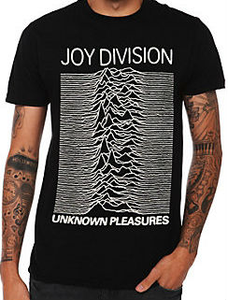

Top Matches


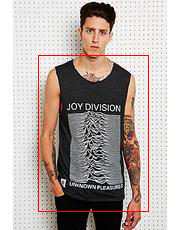

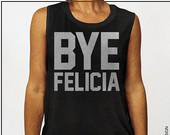

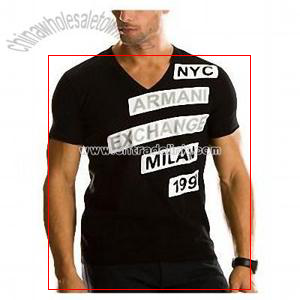

In [130]:
draw_k('images/shirt2.jpg',3,df,f,full_fc6)

Source Image


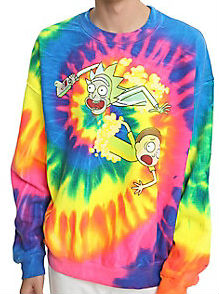

Top Matches


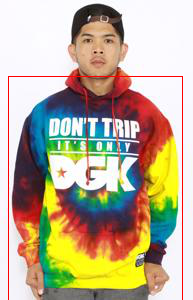

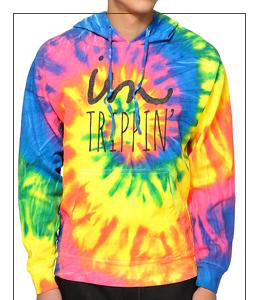

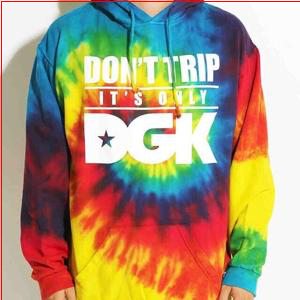

In [131]:
draw_k('images/shirt3.jpg',3,df,f,full_fc6)

Source Image


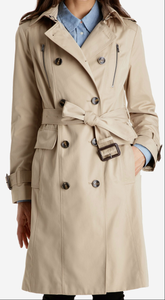

Top Matches


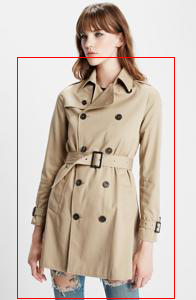

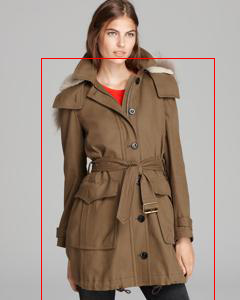

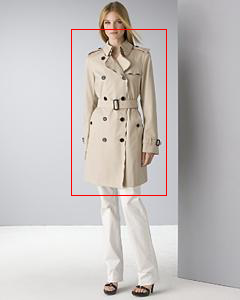

In [136]:
draw_k('images/coat2.jpg',3,df,f,full_fc6)

Source Image


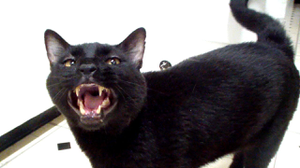

Top Matches


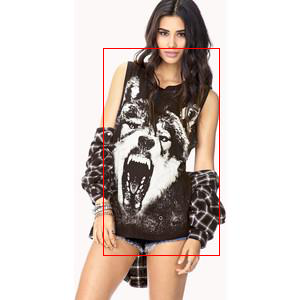

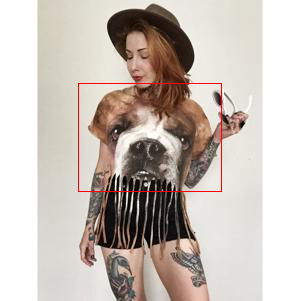

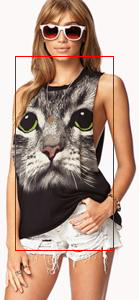

In [137]:
draw_k('images/kitty2.jpg',3,df,f,full_fc6)